# Visualize different cohorts in BASMI data

* TODO: Filter for rehab patients
* TODO: Consider the effect of adding data to `no-treatment` cohort of patients who are later in disease progression$^1$


1. The problem here is that most patients start using no drugs and end up using drugs. However, the time (and age) is a definite factor in disease progression, and by adding data to the `no-treatment` cohort that is mostly later in disease progression we are inducing a bias in that cohort.

In [2]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import data_utils as util

import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set()

In [3]:
demo_df = pd.read_excel('../data/demographics and Biologics data.xlsx', index_col=0)
demo_ids = demo_df.index.values
demo_df.head()

,patient_gender_id,patient_date_of_diagnosis,Age at diagnosis,patient_hla_bUnknown7_id,EIBP,patient_condition_subtype,Current biologic,Number of biologics used (not including brand/biosimilar switch),year of Birth
patient_id,,,,,,,,,
40,Female,1994-01-01,46.255989,Positive,False,AS,Infliximab,1,1947
41,Male,2003-01-01,46.644764,Positive,False,AS,Adalimumab,1,1956
43,Male,1978-01-01,20.410678,Positive,False,AS,Adalimumab,1,1957
44,Male,1994-01-01,22.047912,Unknown,False,AS,Adalimumab,1,1971
45,Male,1998-01-01,37.048597,Positive,False,AS,Etanercept,1,1960


In [4]:
df = pd.read_excel('../data/clean_basmi.xls', index_col=(0,1))
df.head()

CRS  TWS  LSFS  LFS  IMS   BS Drug
patient_id Date                                          
40         1995-05-09    3    1     6    5    3  3.6  NaN
           1995-06-01    3    1     8    5    3  4.0  NaN
           1995-06-12    2    1     5    3    2  2.6  NaN
           1995-11-02    1    1     3    4    2  2.2  NaN
           1996-05-02    2    1     4    3    2  2.4  NaN

## Split BASMI data into different cohorts:

* Treatment: Patients who underwent **any** treatment
* No Treatment: Patients who have **not** had any treatment

To be clear, consider the following example: Patient 40 entered the study and took no biologics and also did not undergo rehab for the first 12 years. However, after 12 years the patient started using a biologic drug. This means that the first 12 years of measurements of patient 40 will be added to the "no treatment" cohort, and the latter will be added to the "treatment" cohort. 



In [5]:
print_ = False

no_drugs_dfs = []
drugs_dfs = []
i = 0
for patient_id, patient_df in df.groupby('patient_id'):
    
    # if we don't have demographic info, skip this patient
    if patient_id not in demo_ids:
        continue
        
    # Add the patient age column
    patient_yob = demo_df.loc[patient_id]['year of Birth']
    
    dates = pd.to_datetime(patient_df.index.get_level_values('Date'))
    
    age = [d.year - patient_yob for d in dates]
    
    patient_df['Age'] = age
    
    no_drugs_df = patient_df[patient_df['Drug'].isnull()]
    drugs_df = patient_df.dropna(how='any')
    
    if print_:
        print(patient_id,'\n')
        print('No Drugs:')
        print(no_drugs_df)
        print('\nDrugs:')
        print(drugs_df)
        print('\n\n')

    # Start date of periods for which patient took biologics
    drugs_dates = drugs_df.index.get_level_values('Date')
    no_drugs_dates = no_drugs_df.index.get_level_values('Date')
    
    drugs_start = min(drugs_dates) if not drugs_dates.empty else None
    no_drugs_start = min(no_drugs_dates) if not no_drugs_dates.empty else None
        
    # if a patient used drugs and then stopped, skip this patient
    if drugs_start and no_drugs_start and drugs_start < no_drugs_start:
        print('patient {} had invalid data'.format(patient_id))
        continue
        
    # If patient had taken drugs, save the data
    if not drugs_df.empty:
        drugs_dfs.append(drugs_df)
    
    # If patient had data for when not taking drugs, save the data
    if not no_drugs_df.empty:
        no_drugs_dfs.append(no_drugs_df)
        
    # Circuit breaker
#     if i == 100:
#         break
        
    i += 1

no_drugs_df = pd.concat(no_drugs_dfs)
drugs_df = pd.concat(drugs_dfs)

/Users/renierbotha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
print('Shape of no drugs dataset: {}'.format(no_drugs_df.shape))
print('Shape of drugs dataset: {}'.format(drugs_df.shape))

Shape of no drugs dataset: (13218, 8)
Shape of drugs dataset: (1218, 8)


In [11]:
# Aggregate over each year
no_drugs_df_agg = no_drugs_df.groupby(['patient_id','Age']).mean()
drugs_df_agg = drugs_df.groupby(['patient_id','Age']).mean()

no_drugs_df_agg.head(20)

CRS       TWS      LSFS       LFS       IMS        BS
patient_id Age                                                            
40         48   2.250000  1.000000  5.500000  4.250000  2.500000  3.100000
           49   2.000000  1.000000  4.000000  3.000000  2.000000  2.400000
           50   3.000000  1.000000  5.000000  4.000000  2.000000  3.000000
           51   3.000000  1.000000  7.000000  4.000000  2.000000  3.400000
           52   2.500000  1.000000  6.000000  5.000000  2.000000  3.300000
           53   3.500000  1.000000  6.000000  3.500000  2.000000  3.200000
           54   2.000000  1.000000  7.000000  3.000000  2.000000  3.000000
           55   3.750000  1.250000  6.750000  4.500000  2.500000  3.750000
           56   2.500000  1.000000  5.000000  4.000000  2.000000  2.900000
           57   2.500000  1.000000  6.000000  3.000000  1.500000  2.800000
           58   2.500000  1.000000  5.500000  3.500000  2.000000  2.900000
           59   2.333333  1.000000  6.000000  3.000000  1.666667  2.800000
           60   2.000000  1.000000  5.000000  3.000000  2.000000  2.600000
41         51   4.666667  3.666667  6.666667  3.666667  1.666667  4.066667
           53   6.500000  5.000000  7.500000  4.000000  2.750000  5.150000
           54   6.000000  5.000000  8.000000  4.000000  3.500000  5.300000
43         37   1.000000  1.000000  4.000000  1.000000  2.000000  1.800000
           38   0.000000  0.000000  1.500000  2.000000  2.000000  1.100000
           39   0.000000  1.000000  1.000000  3.000000  2.000000  1.400000
           46   3.000000  1.000000  1.000000  2.000000  4.000000  2.200000

In [18]:
temp = util.normalize_timeline(drugs_df)
temp

,BS,norm_years
patient_id,,
40,2.930,0.0
40,2.900,1.0
40,2.800,2.0
40,3.400,3.0
40,4.600,4.0
40,3.200,5.0
41,5.800,0.0
41,5.670,1.0
41,5.600,2.0


## Visualize BS score by Age for each cohort

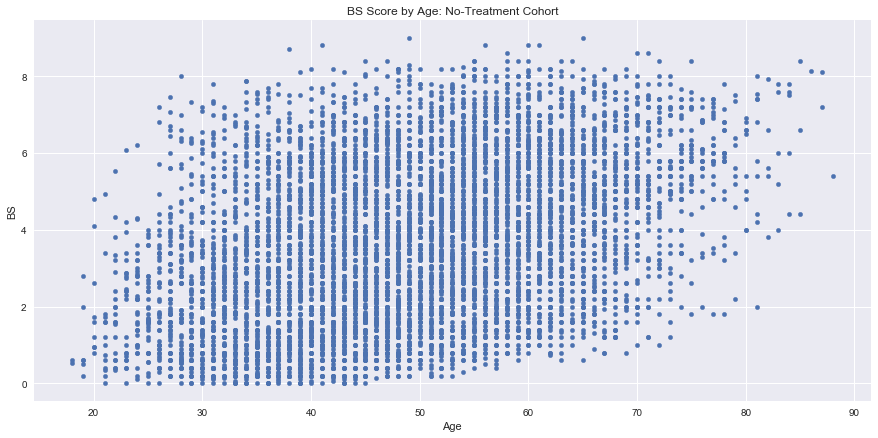

In [16]:
# Take a random sample of the data (2000 points) 
no_drugs_df_agg.reset_index().plot(kind='scatter', x='Age',y='BS', figsize=(15,7), title='BS Score by Age: No-Treatment Cohort')
plt.show()

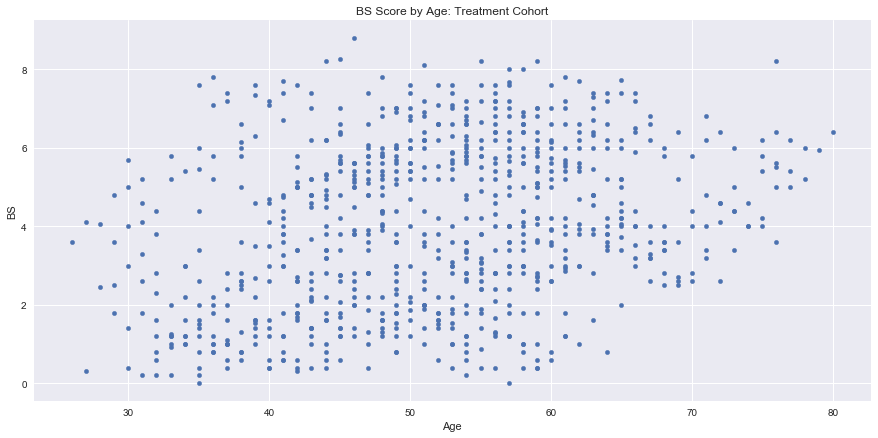

In [15]:
drugs_df_agg.reset_index().plot(kind='scatter', x='Age',y='BS', figsize=(15,7), title='BS Score by Age: Treatment Cohort')
plt.show()

In [68]:
drugs_df.shape

(1218, 8)